# 欠測データ

欠測データ（missing data）は

## 代入法

### 単一代入法

- **平均値代入法**：対象の変数の欠損していないレコードから計算した平均値で代入
- **回帰代入法**：当該レコードの欠損していない他の変数を用いて予測した値で代入

### 多重代入法

1. 疑似乱数から代入する値をサンプリングして代入した複数（$k\in \mathbb{N}$個）のデータセットを作成する
2. 欠測値を補完した$k$個のデータセットで分析を$k$回行う


## MICE

古典的な多重代入法はMCMCだったが、FCSアルゴリズムを使う **MICE（multivvariate imputation by chained equations）** が人気

[高橋将宜, & 伊藤孝之. (2014). 様々な多重代入法アルゴリズムの比較~ 大規模経済系データを用いた分析~. 統計研究彙報, 71(3), 39-82.](https://www.stat.go.jp/training/2kenkyu/ihou/71/pdf/2-2-713.pdf)


### StatsmodelsパッケージのMICE

[Multiple Imputation with Chained Equations - statsmodels 0.14.1](https://www.statsmodels.org/stable/imputation.html)

#### MICEの実行例

In [138]:
# データの生成：完全データ
import numpy as np
np.random.seed(0)

n = 20
x1 = np.random.uniform(size=n)
x2 = np.random.normal(size=n)
e = np.random.normal(size=n)
y = 2 + 5*x1 + 3*x2 + e

import pandas as pd
df_full = pd.DataFrame({"x1": x1, "x2": x2, "y": y})
df_full

,x1,x2,y
0,0.548814,1.494079,10.456595
1,0.715189,-0.205158,6.162852
2,0.602763,0.313068,5.565693
3,0.544883,-0.854096,1.859826
4,0.423655,-2.552990,-4.589248
5,0.645894,0.653619,5.770308
6,0.437587,0.864436,5.074974
7,0.891773,-0.742165,6.183145
8,0.963663,2.269755,13.117925
9,0.383442,-1.454366,-0.883964


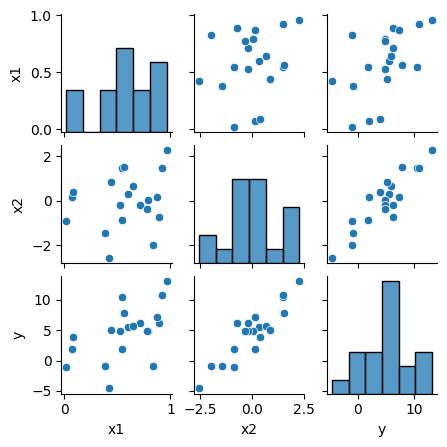

In [139]:
# データの関係
import seaborn as sns
sns.pairplot(df_full, height=1.5)

In [140]:
# 一部を意図的に欠損させる
df = df_full.copy()

missing_idx = df.sample(frac=0.2, random_state=0).index
df.loc[missing_idx, "x1"] = None
df

,x1,x2,y
0,0.548814,1.494079,10.456595
1,NaN,-0.205158,6.162852
2,0.602763,0.313068,5.565693
3,0.544883,-0.854096,1.859826
4,0.423655,-2.552990,-4.589248
5,0.645894,0.653619,5.770308
6,0.437587,0.864436,5.074974
7,0.891773,-0.742165,6.183145
8,NaN,2.269755,13.117925
9,0.383442,-1.454366,-0.883964


#### MICEを使ったデータセット群の生成

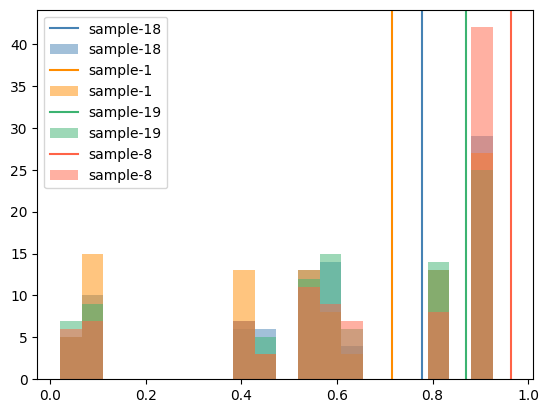

In [141]:
# MICEでデータセットを生成
from statsmodels.imputation import mice

samples = []
imp = mice.MICEData(df, perturbation_method='gaussian', k_pmm=20)
imp.set_imputer(endog_name='x1', formula='y + x2')
for j in range(100):
    imp.update_all()
    samples.append(imp.data.loc[missing_idx, "x1"].to_dict())
samples = pd.DataFrame(samples)

# 代入された値の分布
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
colors = ["steelblue", "darkorange", "mediumseagreen", "tomato"]
for color, i in zip(colors, samples.columns):
    ax.axvline(df_full.loc[i, "x1"], label=f"sample-{i}", color=color)
    ax.hist(samples[i], label=f"sample-{i}", alpha=0.5, color=color, bins=20)
ax.legend()
fig.show()

#### MICEを使って推定

In [142]:
import statsmodels.api as sm
from statsmodels.imputation import mice

imp = mice.MICEData(df)
fml = "y ~ x1 + x2"
m = mice.MICE(fml, sm.OLS, imp)
results = m.fit(n_burnin=10, n_imputations=10)
print(results.summary())

                        Results: MICE
Method:                  MICE      Sample size:          20  
Model:                   OLS       Scale                 1.90
Dependent variable:      y         Num. imputations      10  
-------------------------------------------------------------
          Coef.  Std.Err.    t    P>|t|  [0.025 0.975]  FMI  
-------------------------------------------------------------
Intercept 2.0910   0.8916  2.3453 0.0190 0.3435 3.8385 0.4320
x1        4.6978   1.4068  3.3395 0.0008 1.9406 7.4550 0.3596
x2        3.1663   0.2912 10.8730 0.0000 2.5955 3.7370 0.1961



けっこうズレてる

In [143]:
import statsmodels.formula.api as smf

print(smf.ols(fml, data=df).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.940
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                     102.2
Date:                Mon, 09 Sep 2024   Prob (F-statistic):           1.12e-08
Time:                        05:35:02   Log-Likelihood:                -22.843
No. Observations:                  16   AIC:                             51.69
Df Residuals:                      13   BIC:                             54.00
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.3872      0.610      2.276      0.0

/usr/local/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  res = hypotest_fun_out(*samples, **kwds)


In [144]:
import statsmodels.formula.api as smf

print(smf.ols(fml, data=df_full).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.948
Model:                            OLS   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                     154.6
Date:                Mon, 09 Sep 2024   Prob (F-statistic):           1.24e-11
Time:                        05:35:03   Log-Likelihood:                -27.831
No. Observations:                  20   AIC:                             61.66
Df Residuals:                      17   BIC:                             64.65
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.3384      0.561      2.384      0.0